In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import os, datetime, argparse, tqdm, pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import utils
import mymodels
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


from os.path import join as pjoin

def str2bool(v): 
    if isinstance(v, bool): 
        return v 
    if v.lower() in ('yes', 'true', 't', 'y', '1'): 
        return True 
    elif v.lower() in ('no', 'false', 'f', 'n', '0'): 
        return False 
    else: raise argparse.ArgumentTypeError('Boolean value expected.')


In [4]:
parser = argparse.ArgumentParser()
parser.add_argument('--file_traf', type = str, default = '../prepdata/traffic-volume-A-20180101-20190101.df')
parser.add_argument('--file_coarse', type = str, default = '../prepdata/coarse_grained_lte.h5')
parser.add_argument('--file_fine', type = str, default = '../prepdata/fine_grained_lte.h5')
parser.add_argument('--patch_size', type = int, default = 4)
parser.add_argument('--model_name', type = str, default = 'MyDCGRUSTE0ZCFBU')
parser.add_argument('--memo', type = str, default = 'T0')

parser.add_argument('--train_ratio', type = float, default = 0.7,
                    help = 'training set [default : 0.7]')
parser.add_argument('--val_ratio', type = float, default = 0.1,
                    help = 'validation set [default : 0.1]')
parser.add_argument('--test_ratio', type = float, default = 0.2,
                    help = 'testing set [default : 0.2]')
parser.add_argument('--cnn_size', type = int, default = 3)
parser.add_argument('--P', type = int, default = 6)
parser.add_argument('--Q', type = int, default = 1)
parser.add_argument('--time_slot', type = int, default = 60, 
                    help = 'a time step is 60 mins')

parser.add_argument('--L', type = int, default = 1,
                    help = 'number of STAtt Blocks')
# parser.add_argument('--LZ', type = int, default = 2,
#                     help = 'number of Regional STAtt Blocks')
parser.add_argument('--K', type = int, default = 8,
                    help = 'number of attention heads')
parser.add_argument('--d', type = int, default = 8,
                    help = 'dims of each head attention outputs')
parser.add_argument('--D', type = int, default = 64)
parser.add_argument('--batch_size', type = int, default = 32,
                    help = 'batch size')
parser.add_argument('--max_epoch', type = int, default = 1000,
                    help = 'epoch to run')
parser.add_argument('--patience', type = int, default = 10,
                    help = 'patience for early stop')
parser.add_argument('--learning_rate', type=float, default = 0.001,
                    help = 'initial learning rate')
parser.add_argument('--decay_epoch', type=int, default = 5,
                    help = 'decay epoch')

parser.add_argument('--save_dir', default = 'test',
                    help = 'save_dir')

args = parser.parse_args([])

In [5]:
args.test_name = args.memo + args.model_name

args.model_checkpoint_dir = f'checkpoint/'
args.model_checkpoint = os.path.join(args.model_checkpoint_dir, args.test_name)
args.test_dir = f'test_exp/'

if not os.path.isdir(args.model_checkpoint_dir):
    os.makedirs(args.model_checkpoint_dir)
if not os.path.isdir(args.test_dir):
    os.makedirs(args.test_dir)


(trainX, trainZC, trainZF, trainTE, trainY, 
            valX, valZC, valZF, valTE, valY, 
            testX, testZC, testZF, testTE, testY, extdata) = utils.loadVolumeData2(args)

print(trainX.shape, trainZC.shape, trainZF.shape, trainTE.shape, trainY.shape)
print(valX.shape, valZC.shape, valZF.shape, valTE.shape, valY.shape)
print(testX.shape, testZC.shape, testZF.shape, testTE.shape, testY.shape)

# import sys; sys.exit(0)

#####################################

pred = np.tile(np.expand_dims(testX.mean(axis=1) * extdata['maxval'], 1), [1, args.Q, 1])
label = testY
print('Closeness Mean', utils.metric(pred, label), sep='\t')

pred = np.tile(testX[:, -1:, :] * extdata['maxval'], [1, args.Q, 1])
label = testY
print('Closeness Last', utils.metric(pred, label), sep='\t')

pred = trainY.mean(0)[np.newaxis, :, :]
label = testY
print('Historical Avg', utils.metric(pred, label), sep='\t')

#####################################

def model_define():
    X = layers.Input(shape=trainX.shape[1:], dtype=tf.float32)
    ZC = layers.Input(shape=trainZC.shape[1:], dtype=tf.float32)
    ZF = layers.Input(shape=trainZF.shape[1:], dtype=tf.float32)
    TE = layers.Input(shape=trainTE.shape[1:], dtype=tf.int32) # int32

    Y = mymodels.ModelSet(model_name=args.model_name, extdata=extdata, args=args, X=X, ZC=ZC, ZF=ZF, TE=TE)
    model = keras.models.Model((X, ZC, ZF, TE), Y)
    return model

model = model_define()
# model.summary()
# optimizer = keras.optimizers.Adam(lr=args.learning_rate)

def custom_mape_loss(label, pred):
    mask = tf.not_equal(label, 0)
    mask = tf.cast(mask, tf.float32)
    mask /= tf.reduce_mean(mask)
    mask = tf.compat.v2.where(
        condition = tf.math.is_nan(mask), x = 0., y = mask)
    # loss = tf.abs(tf.subtract(pred, label))
    loss = 100 * abs((pred - label) / (label+1e-3))
    loss *= mask
    loss = tf.compat.v2.where(
        condition = tf.math.is_nan(loss), x = 0., y = loss)
    loss = tf.reduce_mean(loss)
    return loss

# model.compile(loss=custom_mape_loss, optimizer=optimizer)

# Define some callbacks to improve training.
# early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=args.patience)
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=args.decay_epoch)
# model_ckpt = tf.keras.callbacks.ModelCheckpoint(args.model_checkpoint, save_weights_only=True, save_best_only=True, monitor='val_loss', mode='min', verbose=0)


# model.fit(
#     (trainX, trainZC, trainZF, trainTE), trainY,
#     batch_size=args.batch_size,
#     epochs=args.max_epoch,
#     validation_data=((valX, valZC, valZF, valTE), valY),
#     callbacks=[early_stopping, reduce_lr, model_ckpt],
# )

model = model_define()
model.load_weights(args.model_checkpoint)

pred = model.predict((testX, testZC, testZF, testTE))
label = testY
print(f'{args.model_name}', utils.metric(pred, label), sep='\t')


# np.save(f'{args.test_dir}/label.npy', label)
# np.save(f'{args.test_dir}/pred_{args.test_name}.npy', pred)


(1540, 6, 48) (1540, 6, 31, 38) (1540, 6, 30, 33) (1540, 7, 2) (1540, 1, 48)
(214, 6, 48) (214, 6, 31, 38) (214, 6, 30, 33) (214, 7, 2) (214, 1, 48)
(436, 6, 48) (436, 6, 31, 38) (436, 6, 30, 33) (436, 7, 2) (436, 1, 48)
Closeness Mean	(315.33313, 437.94702, 0.6311842347798032)
Closeness Last	(132.28763, 208.062, 0.20889542323962526)
Historical Avg	(399.7727, 516.35205, 1.047419830074578)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
SE <dtype: 'float32'> TE <dtype: 'int32'>
SE <dtype: 'float32'> TE <dtype: 'int32'>
SE <dtype: 'float32'> TE <dtype: 'int32'>


2022-09-29 14:17:50.577298: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-09-29 14:17:50.701216: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:04:00.0
2022-09-29 14:17:50.701639: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-09-29 14:17:50.703237: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-09-29 14:17:50.704601: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2022-09-29 14:17:50.704974: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2022-09-29 14:17:50.706840: I tensorflow/stream_executor

SE <dtype: 'float32'> TE <dtype: 'int32'>
SE <dtype: 'float32'> TE <dtype: 'int32'>
SE <dtype: 'float32'> TE <dtype: 'int32'>


2022-09-29 14:17:55.343008: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-09-29 14:17:55.547223: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


MyDCGRUSTE0ZCFBU	(52.792538, 95.83111, 0.08121004556779304)


In [6]:
traf_df = pd.read_hdf('../prepdata/traffic-volume-A-20180101-20190101.df')
warns = np.isnan(traf_df.iloc[24*59:24*151]).sum(0) > 900

In [7]:
print(f'{args.model_name}', utils.metric(pred[..., ~warns], label[..., ~warns]), sep='\t')

MyDCGRUSTE0ZCFBU	(50.623768, 93.11515, 0.07989559268620627)


In [8]:
import matplotlib.pyplot as plt

In [9]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
# W1 = model.layers[4].FC_ZC_trans.weights[0]
# array = W1.eval(sess)
# array = array.reshape(extdata['CH']-2, extdata['CW']-2, 48)

2022-09-29 14:17:58.374509: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:04:00.0
2022-09-29 14:17:58.374639: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-09-29 14:17:58.374718: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-09-29 14:17:58.374767: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2022-09-29 14:17:58.374803: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2022-09-29 14:17:58.374838: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10.0
2022-09-29 14:17:58.374872: I tensorflow/stream_e

<tf.Variable 'my_dcgrust_e0zcfbu_1/conv_lst_m2d_6/kernel:0' shape=(3, 3, 64, 256) dtype=float32>

In [16]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
W1 = model.layers[4].FC_ZF_ConvLSTM.weights[0]
array = W1.eval(sess)

2022-09-29 14:19:55.159627: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:04:00.0
2022-09-29 14:19:55.159833: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-09-29 14:19:55.159904: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-09-29 14:19:55.159951: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2022-09-29 14:19:55.159990: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2022-09-29 14:19:55.160029: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10.0
2022-09-29 14:19:55.160067: I tensorflow/stream_e

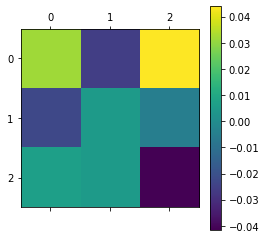

In [40]:
plt.matshow(array[:, :, 8, 16])
plt.colorbar()

In [9]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
W1 = model.layers[4].FC_ZC_trans.weights[0]
array = W1.eval(sess)
array = array.reshape(extdata['CH']-2, extdata['CW']-2, 48)

2022-09-28 13:28:26.401025: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:04:00.0
2022-09-28 13:28:26.401195: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-09-28 13:28:26.401262: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-09-28 13:28:26.401316: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2022-09-28 13:28:26.401388: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2022-09-28 13:28:26.401443: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10.0
2022-09-28 13:28:26.401495: I tensorflow/stream_e

In [10]:
from ipywidgets import *

In [11]:
def f(i):
    plt.matshow(array[..., i])
    plt.colorbar()
    plt.show()
    plt.matshow(array.mean(-1))
    plt.colorbar()
    plt.show()


interact(f, i=(0, array.shape[-1]-1))    

interactive(children=(IntSlider(value=23, description='i', max=47), Output()), _dom_classes=('widget-interact'…

<function __main__.f(i)>